In [1]:
%pylab inline
figsize(10,5)
matplotlib.rcParams["image.interpolation"] = "none"
matplotlib.rcParams["image.cmap"] = "afmhot"

Populating the interactive namespace from numpy and matplotlib


In [4]:
import clstm
import h5py

# LSTM + CTC Training on MNIST

Let's start by getting the MNIST dataset. This version of MNIST in HDF5 represents images in a sequence format suitable for training with `clstm` command line models.

In [7]:
!test -f mnist_seq.h5 || curl http://www.tmbdev.net/ocrdata-hdf5/mnist_seq.h5 > mnist_seq.h5 || rm -f mnist_seq.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49.5M  100 49.5M    0     0  1790k      0  0:00:28  0:00:28 --:--:-- 1793k


In HDF5 data files for CLSTM, row `t` represents the input vector at time step `t`. For MNIST, we scan through the original image left-to-right over time.

Image storage in HDF5 would have to be a rank 3 doubly ragged array, but HDF5 supports only rank 2 arrays. We therefore store image dimensions in a separate array.

(60000,)


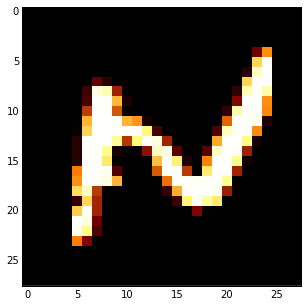

In [8]:
h5 = h5py.File("mnist_seq.h5","r")
imshow(h5["images"][0].reshape(*h5["images_dims"][0]))
print h5["images"].shape

Let's use a bidirectional LSTM and a fiarly high learning rate.

In [9]:
net = clstm.make_net("BIDILSTM")
net.set("ninput",28)
net.set("nhidden",10)
net.set("noutput",11)
net.setLearningRate(1e-2,0.9)
net.initialize()
print clstm.network_info(net)

.bidilstm: 0.010000 0.900000 28 11
.bidilstm.parallel: 0.000100 0.900000 28 20
.bidilstm.parallel.lstm: 0.000100 0.900000 28 10
.bidilstm.parallel.reversed: 0.000100 0.900000 28 10
.bidilstm.parallel.reversed.lstm: 0.000100 0.900000 28 10
.bidilstm.softmax: 0.000100 0.900000 20 11



The class labels in the dataset are such that digit `0` has been assigned class `10`, since class 0 is reserved for epsilon states in CTC alignment.

In [10]:
print [chr(c) for c in h5["codec"]]

['\x00', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']


5


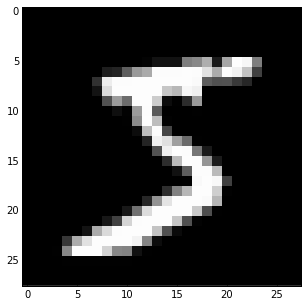

In [11]:
index = 0
xs = array(h5["images"][index].reshape(28,28,1),'f')
cls = h5["transcripts"][index][0]
print cls
imshow(xs.reshape(28,28).T,cmap=cm.gray)

Forward propagation is quite simple: we take the input data and put it into the input sequence of the network, call the `forward` method, and take the result out of the output sequence.

Note that all sequences (including `xs`) in clstm are of rank 3, with indexes giving the time step, the feature dimension, and the batch index, in order.

The output from the network is a vector of posterior probabilities at each time step.

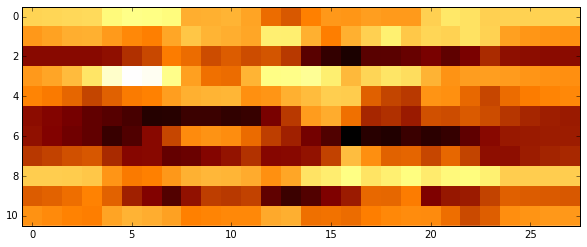

In [12]:
net.inputs.aset(xs)
net.forward()
pred = net.outputs.array()
imshow(pred.reshape(28,11).T, interpolation='none')

We now construct a "target" array and perform CTC alignment with the output.

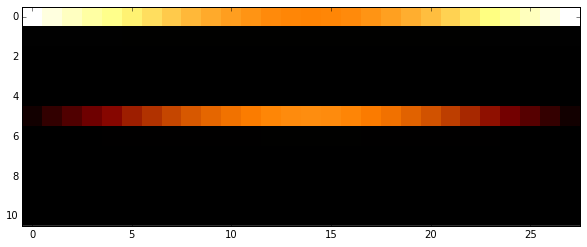

In [13]:
target = zeros((3,11),'f')
target[0,0] = 1
target[2,0] = 1
target[1,cls] = 1
seq = clstm.Sequence()
seq.aset(target.reshape(3,11,1))
aligned = clstm.Sequence()
clstm.seq_ctc_align(aligned,net.outputs,seq)
aligned = aligned.array()
imshow(aligned.reshape(28,11).T, interpolation='none')

Next, we take the aligned output, subtract the actual output, set that as the output deltas, and the propagate the error backwards and update.

In [14]:
deltas = aligned - net.outputs.array()
net.d_outputs.aset(deltas)
net.backward()
net.update()

If we repeat these steps over and over again, we eventually end up with a trained network.

In [15]:
for i in range(60000):
    index = int(rand()*60000)
    xs = array(h5["images"][index].reshape(28,28,1),'f')
    cls = h5["transcripts"][index][0]
    net.inputs.aset(xs)
    net.forward()
    pred = net.outputs.array()
    target = zeros((3,11),'f')
    target[0,0] = 1
    target[2,0] = 1
    target[1,cls] = 1
    seq = clstm.Sequence()
    seq.aset(target.reshape(3,11,1))
    aligned = clstm.Sequence()
    clstm.seq_ctc_align(aligned,net.outputs,seq)
    aligned = aligned.array()
    deltas = aligned - net.outputs.array()
    net.d_outputs.aset(deltas)
    net.backward()
    net.update()

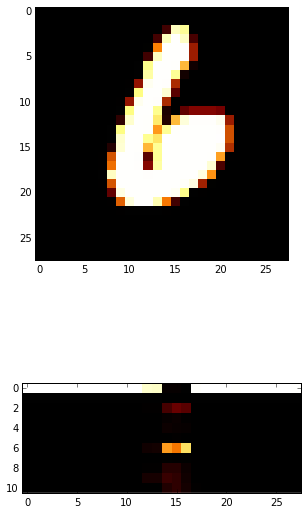

In [16]:
figsize(5,10)
subplot(211,aspect=1)
imshow(xs.reshape(28,28).T)
subplot(212,aspect=1)
imshow(pred.reshape(28,11).T, interpolation='none', vmin=0, vmax=1)